# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.ensemble import RandomForestClassifier
import pydot
from IPython.display import Image
from mlxtend import plotting
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

## Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAP = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

## Extracted Features

In [3]:
ACTIVITY_CODES_MAPPING = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}
EXTRACTED_FEATURES = ['ACTIVITY',
                        'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
                        'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
                        'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9',
                        'XAVG', 'YAVG', 'ZAVG',
                        'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
                        'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV',
                        'XVAR', 'YVAR', 'ZVAR',
                        'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
                        'XMFCC5', 'XMFCC6', 'XMFCC7',
                        'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12',
                        'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4',
                        'YMFCC5', 'YMFCC6', 'YMFCC7',
                        'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
                        'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4',
                        'ZMFCC5', 'ZMFCC6', 'ZMFCC7',
                        'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12',
                        'XYCOS', 'XZCOS', 'YZCOS',
                        'XYCOR', 'XZCOR', 'YZCOR',
                        'RESULTANT',
                        'PARTICIPANT'] # Categirical: 1600 -1650


EXTRACTED_FEATURES_ONLY = [
                        'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
                        'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
                        'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9',
                        'XAVG', 'YAVG', 'ZAVG',
                        'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
                        'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV',
                        'XVAR', 'YVAR', 'ZVAR',
                        'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
                        'XMFCC5', 'XMFCC6', 'XMFCC7',
                        'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12',
                        'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4',
                        'YMFCC5', 'YMFCC6', 'YMFCC7',
                        'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
                        'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4',
                        'ZMFCC5', 'ZMFCC6', 'ZMFCC7',
                        'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12',
                        'XYCOS', 'XZCOS', 'YZCOS',
                        'XYCOR', 'XZCOR', 'YZCOR',
                        'RESULTANT'] # Categorical: 1600 -1650

len(EXTRACTED_FEATURES)


90

## Dataset

In [4]:
def get_activity_code(activity_names):
    cat_len=len(activity_names)
    activity_code={}
    for idx, an in enumerate(activity_names):
        for k in ACTIVITY_CODES_MAPPING.keys() :
            if ACTIVITY_CODES_MAPPING[k]==an:
                key = k
        activity_code[key]=idx

    assert(len(activity_code.keys())== cat_len)

    print(f"{activity_code}")
    print(f"Number of Categories {cat_len}")
    return activity_code, cat_len

def WISDM_Dataset(data_dir, activity_code):
    dataset_train = pd.DataFrame()
    for i, dr in enumerate(data_dir):
        all_files = glob.glob(dr + "/*.txt")

        list_dfs = []
        for filename in all_files:
            df = pd.read_csv(filename, names = EXTRACTED_FEATURES, index_col=None, header=None)
            df = df[df['ACTIVITY'].isin(activity_code)]
            list_dfs.append(df)

        all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)
        if i > 0:
            all_data = all_data[EXTRACTED_FEATURES_ONLY]
        dataset_train = pd.concat([dataset_train,all_data.add_suffix(str(i))],axis=1)

    return dataset_train


## Training on Phone

### Hyper parameters

In [5]:
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]

NUM_SPLITS=5
TRAIN_SPLIT=0.8
TEST_SPLIT=1 - TRAIN_SPLIT

my_param_grid = {'bootstrap': [True],
                 'n_estimators': [50, 100, 200],
                 'oob_score': [True, False],
                 'warm_start': [True, False]}
DATA_DIR=["../dataset/processed/phone/accel",
          "../dataset/processed/phone/gyro"]

### Initialize Dataset

In [6]:
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
all_phone = WISDM_Dataset(DATA_DIR, activity_code)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_phone.drop('PARTICIPANT0', axis = 1, inplace = True)

y = all_phone.ACTIVITY0
X = all_phone.drop('ACTIVITY0', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SPLIT,
                                                    test_size = TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features_orig=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
rescalin_features=[]
for i in range(len(DATA_DIR)):
    for rf in rescalin_features_orig:
        rescalin_features.append(rf+str(i))
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17}
Number of Categories 18


In [7]:
X_train.columns

Index(['X00', 'X10', 'X20', 'X30', 'X40', 'X50', 'X60', 'X70', 'X80', 'X90',
       ...
       'ZMFCC101', 'ZMFCC111', 'ZMFCC121', 'XYCOS1', 'XZCOS1', 'YZCOS1',
       'XYCOR1', 'XZCOR1', 'YZCOR1', 'RESULTANT1'],
      dtype='object', length=176)

### Training

In [8]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SPLIT,
                               test_size=TEST_SPLIT)

rf_classifier = RandomForestClassifier()
rf_model_gs = GridSearchCV(estimator = rf_classifier,
                           param_grid = my_param_grid,
                           n_jobs=-1,
                           scoring = 'accuracy',
                           cv = my_cv)
rf_model_gs.fit(X_train, y_train)
rf_best_classifier = rf_model_gs.best_estimator_
print(rf_model_gs.best_params_)
print(rf_model_gs.cv_results_)
print(rf_best_classifier.get_params())

{'bootstrap': True, 'n_estimators': 200, 'oob_score': True, 'warm_start': False}
{'mean_fit_time': array([ 8.24928503,  8.22939863,  7.97843599,  7.94518909, 16.42670403,
       16.35949359, 15.86033616, 15.88905926, 30.91674576, 28.19254451,
       26.18174915, 26.32016716]), 'std_fit_time': array([0.02063163, 0.06003745, 0.04942608, 0.03124305, 0.03719195,
       0.09233898, 0.08561515, 0.05691782, 2.21952944, 2.93652291,
       2.6184387 , 1.53686761]), 'mean_score_time': array([0.0635047 , 0.06137872, 0.076542  , 0.07726827, 0.08312292,
       0.08766041, 0.10369005, 0.12043777, 0.13847003, 0.12214174,
       0.11363006, 0.11652884]), 'std_score_time': array([0.00495917, 0.00943368, 0.00330395, 0.00376318, 0.00320519,
       0.00679148, 0.01123224, 0.01246874, 0.01808287, 0.01219342,
       0.00181793, 0.00420254]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True],
             mask=[False, False, False

### Evaluation

#### Train Accuracy

In [9]:
scores = cross_val_score(rf_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

rf_best_classifier.score(X_train, y_train)
y_train_pred = rf_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.7722323049001815, 0.7586206896551724, 0.7717785843920145, 0.7754083484573503, 0.7763157894736842]
######################################################################################
train accuracy: 100.0
######################################################################################


#### Confusion Matrix

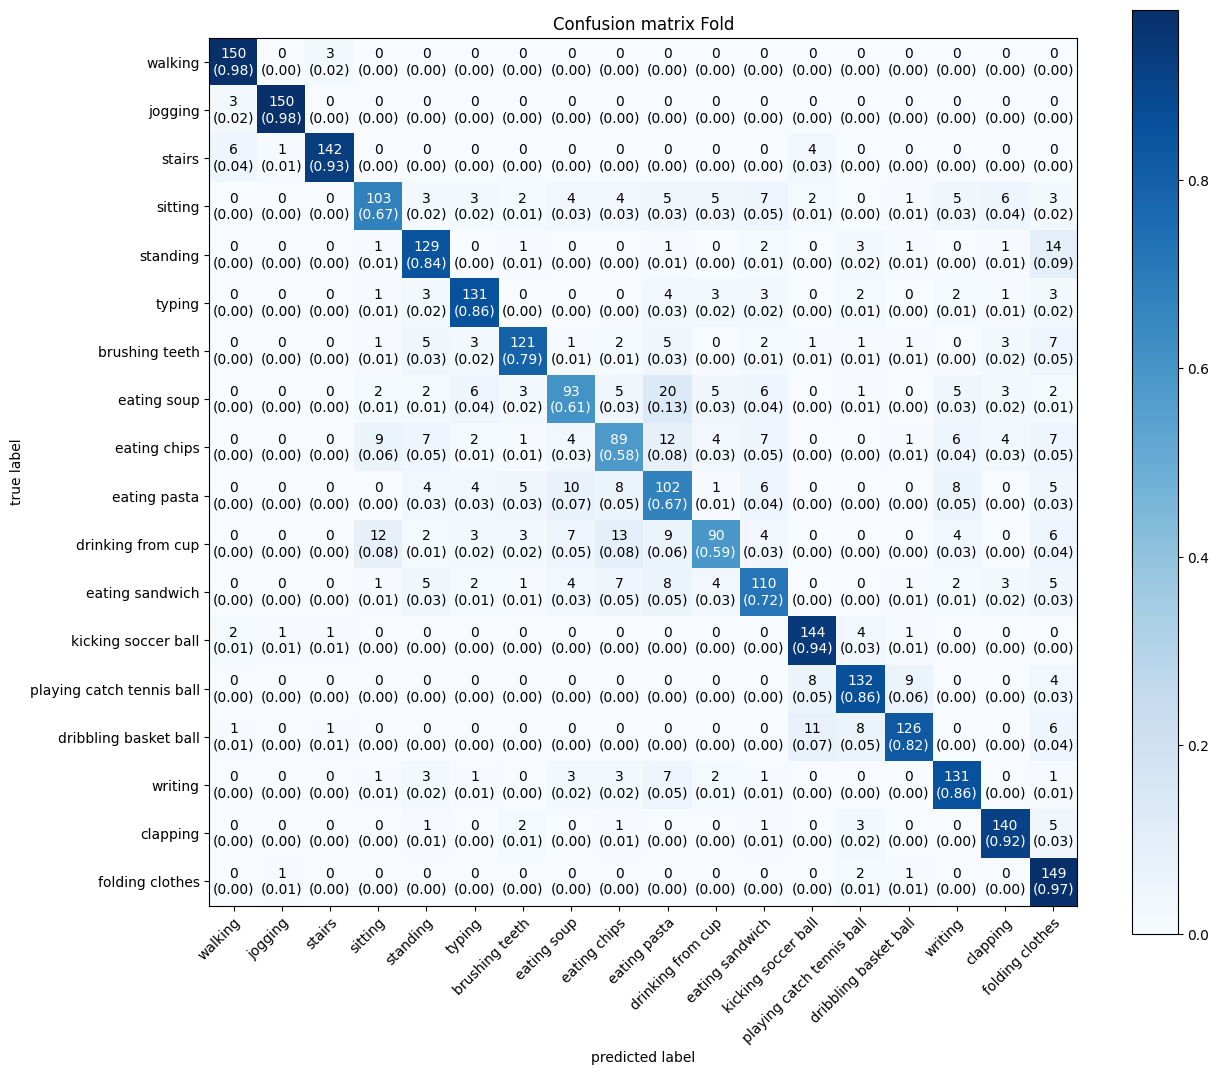

In [10]:
y_test_pred = rf_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [11]:
cm_act = pd.DataFrame(conf_matrix,
                      index=rf_best_classifier.classes_,
                      columns=rf_best_classifier.classes_)

cm_act.columns = ACTIVITY_NAMES
cm_act.index = ACTIVITY_NAMES
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)
print(accuracy_per_activity)

                                  0
walking                    0.980392
jogging                    0.980392
stairs                     0.928105
sitting                    0.673203
standing                   0.843137
typing                     0.856209
brushing teeth             0.790850
eating soup                0.607843
eating chips               0.581699
eating pasta               0.666667
drinking from cup          0.588235
eating sandwich            0.718954
kicking soccer ball        0.941176
playing catch tennis ball  0.862745
dribbling basket ball      0.823529
writing                    0.856209
clapping                   0.915033
folding clothes            0.973856


/tmp/ipykernel_2430969/3252733793.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)


#### Classification Report

In [12]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.93      0.98      0.95       153
           B       0.98      0.98      0.98       153
           C       0.97      0.93      0.95       153
           D       0.79      0.67      0.73       153
           E       0.79      0.84      0.81       153
           F       0.85      0.86      0.85       153
           G       0.87      0.79      0.83       153
           H       0.74      0.61      0.67       153
           I       0.67      0.58      0.62       153
           J       0.59      0.67      0.63       153
           K       0.79      0.59      0.67       153
           L       0.74      0.72      0.73       153
           M       0.85      0.94      0.89       153
           O       0.85      0.86      0.85       153
           P       0.89      0.82      0.85       153
           Q       0.80      0.86      0.83       153
           R       0.87      0.92      0.89       153
           S       0.69    

#### Test Accuracy

In [13]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 81.04575163398692


## Training on Watch

### Hyper parameters

In [14]:
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]
NUM_SPLITS=5
TRAIN_SPLIT=0.8
TEST_SPLIT=0.2

my_param_grid = {'bootstrap': [True],
                 'n_estimators': [50, 100, 200],
                 'oob_score': [True, False],
                 'warm_start': [True, False]}
DATA_DIR=["../dataset/processed/watch/gyro",
          "../dataset/processed/watch/accel"]

### Initialize Dataset

In [15]:
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
all_watch = WISDM_Dataset(DATA_DIR, activity_code)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch.drop('PARTICIPANT0', axis = 1, inplace = True)

y = all_watch.ACTIVITY0
X = all_watch.drop('ACTIVITY0', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SPLIT,
                                                    test_size = TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features_orig=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
rescalin_features=[]
for i in range(len(DATA_DIR)):
    for rf in rescalin_features_orig:
        rescalin_features.append(rf+str(i))
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17}
Number of Categories 18


In [16]:
X_train.columns

Index(['X00', 'X10', 'X20', 'X30', 'X40', 'X50', 'X60', 'X70', 'X80', 'X90',
       ...
       'ZMFCC101', 'ZMFCC111', 'ZMFCC121', 'XYCOS1', 'XZCOS1', 'YZCOS1',
       'XYCOR1', 'XZCOR1', 'YZCOR1', 'RESULTANT1'],
      dtype='object', length=176)

### Training

In [17]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SPLIT,
                               test_size=TEST_SPLIT)

rf_classifier = RandomForestClassifier()
rf_model_gs = GridSearchCV(estimator = rf_classifier,
                           param_grid = my_param_grid,
                           n_jobs=-1,
                           scoring = 'accuracy',
                           cv = my_cv)
rf_model_gs.fit(X_train, y_train)
rf_best_classifier = rf_model_gs.best_estimator_
print(rf_model_gs.best_params_)
print(rf_model_gs.cv_results_)
print(rf_best_classifier.get_params())

{'bootstrap': True, 'n_estimators': 200, 'oob_score': False, 'warm_start': True}
{'mean_fit_time': array([ 7.29314194,  7.29207826,  7.03762751,  7.03275337, 14.46984792,
       14.5096663 , 13.96255994, 13.97851095, 28.67116303, 23.82177405,
       21.89756651, 24.34502978]), 'std_fit_time': array([0.08469428, 0.03811771, 0.03972175, 0.04910177, 0.08986661,
       0.04871533, 0.04448887, 0.08677262, 0.3435823 , 1.56829802,
       1.69460108, 0.63504668]), 'mean_score_time': array([0.04657888, 0.04662142, 0.05929027, 0.05939164, 0.07187777,
       0.07582531, 0.08787985, 0.08851252, 0.11243773, 0.09685402,
       0.09869337, 0.09534965]), 'std_score_time': array([0.00529347, 0.0022187 , 0.00496822, 0.00260928, 0.0036274 ,
       0.00367109, 0.00485737, 0.00583454, 0.01767261, 0.004548  ,
       0.00169144, 0.00296758]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True],
             mask=[False, False, False

### Evaluation

#### Train Accuracy

In [18]:
scores = cross_val_score(rf_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

rf_best_classifier.score(X_train, y_train)
y_train_pred = rf_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.8938294010889292, 0.8820326678765881, 0.9024500907441017, 0.8806715063520871, 0.8892921960072595]
######################################################################################
train accuracy: 100.0
######################################################################################


### Confusion Matrix

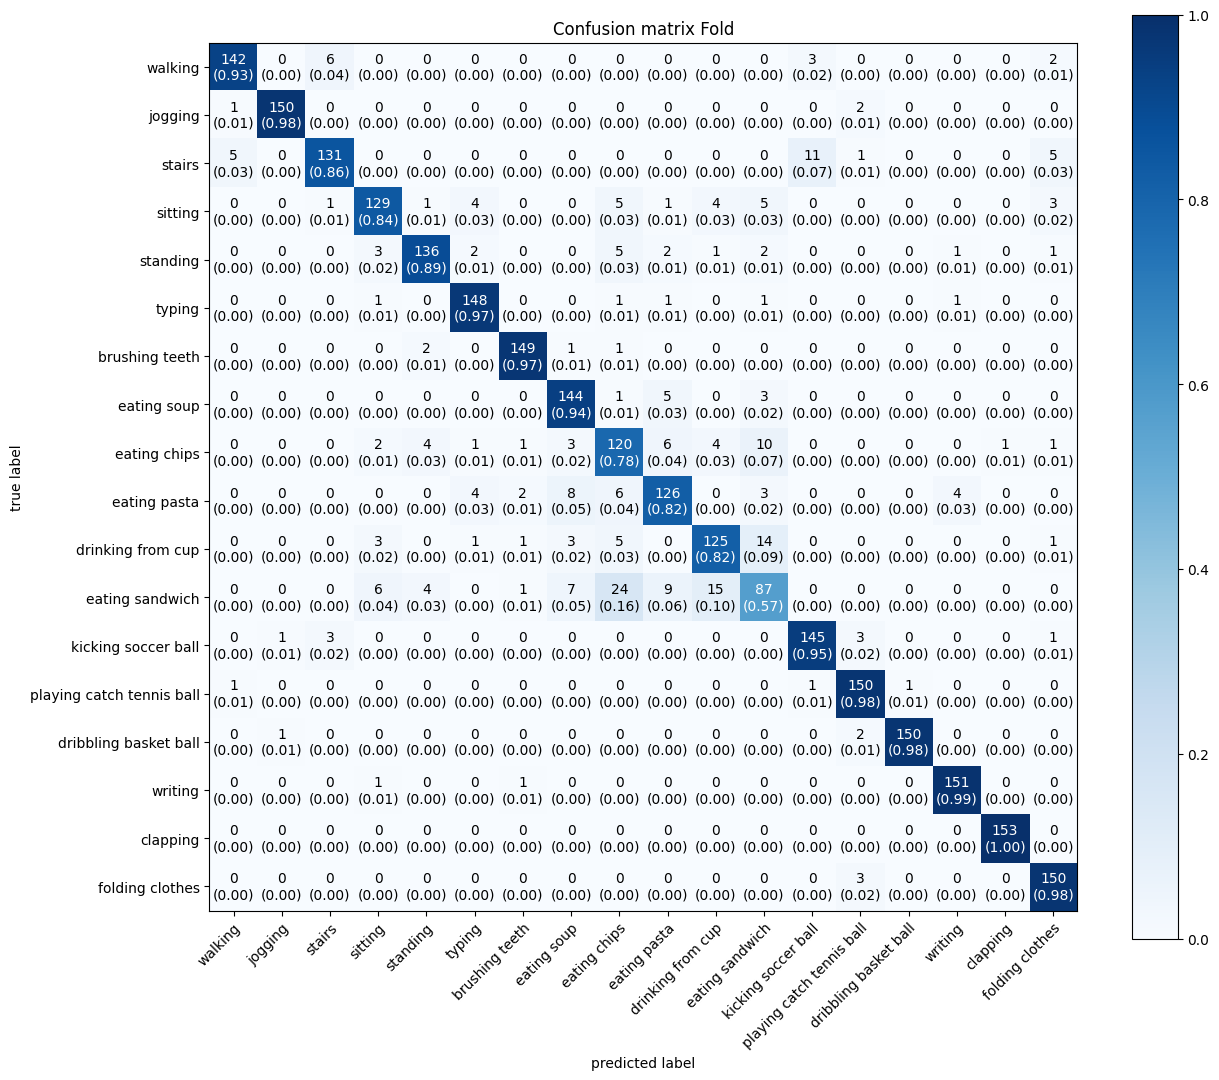

In [19]:
y_test_pred = rf_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

### Accuracy Per Activity

In [20]:
cm_act = pd.DataFrame(conf_matrix,
                      index=rf_best_classifier.classes_,
                      columns=rf_best_classifier.classes_)

cm_act.columns = ACTIVITY_NAMES
cm_act.index = ACTIVITY_NAMES
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)
print(accuracy_per_activity)

                                  0
walking                    0.928105
jogging                    0.980392
stairs                     0.856209
sitting                    0.843137
standing                   0.888889
typing                     0.967320
brushing teeth             0.973856
eating soup                0.941176
eating chips               0.784314
eating pasta               0.823529
drinking from cup          0.816993
eating sandwich            0.568627
kicking soccer ball        0.947712
playing catch tennis ball  0.980392
dribbling basket ball      0.980392
writing                    0.986928
clapping                   1.000000
folding clothes            0.980392


/tmp/ipykernel_2430969/3252733793.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)


### Classification Report

In [21]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.95      0.93      0.94       153
           B       0.99      0.98      0.98       153
           C       0.93      0.86      0.89       153
           D       0.89      0.84      0.87       153
           E       0.93      0.89      0.91       153
           F       0.93      0.97      0.95       153
           G       0.96      0.97      0.97       153
           H       0.87      0.94      0.90       153
           I       0.71      0.78      0.75       153
           J       0.84      0.82      0.83       153
           K       0.84      0.82      0.83       153
           L       0.70      0.57      0.63       153
           M       0.91      0.95      0.93       153
           O       0.93      0.98      0.96       153
           P       0.99      0.98      0.99       153
           Q       0.96      0.99      0.97       153
           R       0.99      1.00      1.00       153
           S       0.91    

### Test Accuracy

In [22]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 90.26870007262164


## Training on All 4 sensors

### Hyper parameters

In [23]:
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]
NUM_SPLITS=5
TRAIN_SPLIT=0.8
TEST_SPLIT=0.2

my_param_grid = {'bootstrap': [True],
                 'n_estimators': [50, 100, 200],
                 'oob_score': [True, False],
                 'warm_start': [True, False]}
DATA_DIR=["../dataset/processed/phone/gyro",
          "../dataset/processed/phone/accel",
           "../dataset/processed/watch/gyro",
          "../dataset/processed/watch/accel"]

### Initialize Dataset

In [24]:
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
all_sensor = WISDM_Dataset(DATA_DIR, activity_code)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_sensor.drop('PARTICIPANT0', axis = 1, inplace = True)

y = all_sensor.ACTIVITY0
X = all_sensor.drop('ACTIVITY0', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SPLIT,
                                                    test_size = TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features_orig=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
rescalin_features=[]
for i in range(len(DATA_DIR)):
    for rf in rescalin_features_orig:
        rescalin_features.append(rf+str(i))
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17}
Number of Categories 18


In [25]:
X_train.columns

Index(['X00', 'X10', 'X20', 'X30', 'X40', 'X50', 'X60', 'X70', 'X80', 'X90',
       ...
       'ZMFCC103', 'ZMFCC113', 'ZMFCC123', 'XYCOS3', 'XZCOS3', 'YZCOS3',
       'XYCOR3', 'XZCOR3', 'YZCOR3', 'RESULTANT3'],
      dtype='object', length=352)

### Training

In [26]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SPLIT,
                               test_size=TEST_SPLIT)

rf_classifier = RandomForestClassifier()
rf_model_gs = GridSearchCV(estimator = rf_classifier,
                           param_grid = my_param_grid,
                           n_jobs=-1,
                           scoring = 'accuracy',
                           cv = my_cv)
rf_model_gs.fit(X_train, y_train)
rf_best_classifier = rf_model_gs.best_estimator_
print(rf_model_gs.best_params_)
print(rf_model_gs.cv_results_)
print(rf_best_classifier.get_params())

{'bootstrap': True, 'n_estimators': 200, 'oob_score': False, 'warm_start': False}
{'mean_fit_time': array([10.1606729 , 10.23031836,  9.8424448 ,  9.8051301 , 20.25674953,
       20.23678479, 19.36083112, 19.38758159, 38.26091647, 35.12237148,
       30.85021496, 33.62744942]), 'std_fit_time': array([0.10816809, 0.17091716, 0.16807912, 0.18075588, 0.07011869,
       0.09064575, 0.14102752, 0.10130554, 3.87072359, 4.03184349,
       3.91017849, 0.7774953 ]), 'mean_score_time': array([0.05916572, 0.05608726, 0.06377258, 0.06380887, 0.09168253,
       0.08910079, 0.11261792, 0.11245599, 0.15093808, 0.10452704,
       0.10676436, 0.10133348]), 'std_score_time': array([0.00277899, 0.00625266, 0.00673653, 0.00290367, 0.00516434,
       0.00619074, 0.01181371, 0.00457481, 0.02284204, 0.00602874,
       0.00419848, 0.00267746]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True],
             mask=[False, False, Fals

### Evaluation

#### Train Accuracy

In [27]:
scores = cross_val_score(rf_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

rf_best_classifier.score(X_train, y_train)
y_train_pred = rf_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.9165154264972777, 0.9083484573502723, 0.9065335753176044, 0.9169691470054446, 0.9165154264972777]
######################################################################################
train accuracy: 100.0
######################################################################################


### Confusion Matrix

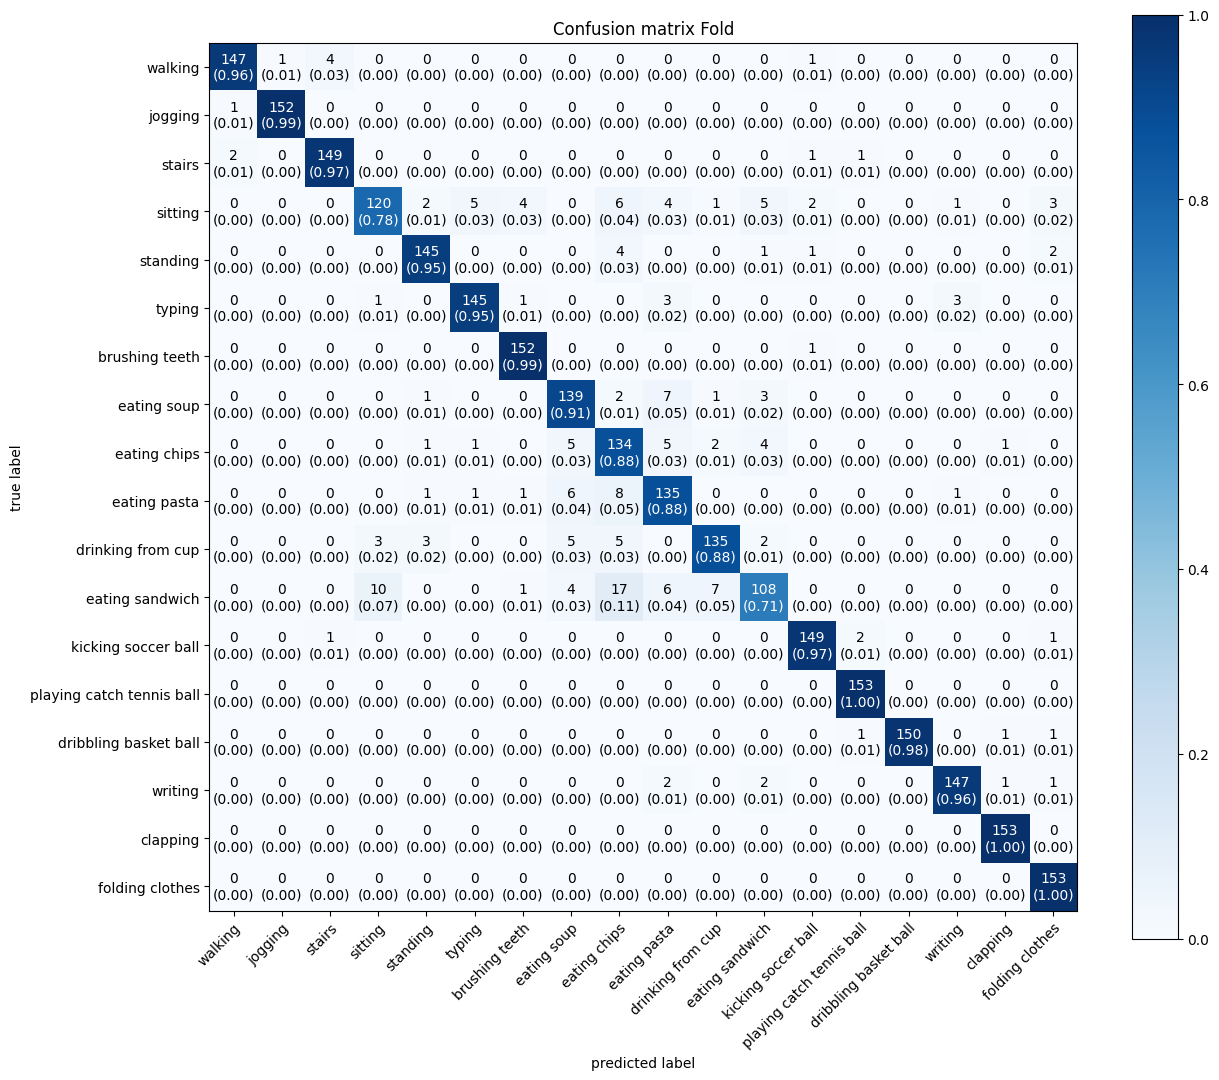

In [28]:
y_test_pred = rf_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

### Accuracy Per Activity

In [29]:
cm_act = pd.DataFrame(conf_matrix,
                      index=rf_best_classifier.classes_,
                      columns=rf_best_classifier.classes_)

cm_act.columns = ACTIVITY_NAMES
cm_act.index = ACTIVITY_NAMES
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)
print(accuracy_per_activity)

                                  0
walking                    0.960784
jogging                    0.993464
stairs                     0.973856
sitting                    0.784314
standing                   0.947712
typing                     0.947712
brushing teeth             0.993464
eating soup                0.908497
eating chips               0.875817
eating pasta               0.882353
drinking from cup          0.882353
eating sandwich            0.705882
kicking soccer ball        0.973856
playing catch tennis ball  1.000000
dribbling basket ball      0.980392
writing                    0.960784
clapping                   1.000000
folding clothes            1.000000


/tmp/ipykernel_2430969/3252733793.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)


### Classification Report

In [30]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.98      0.96      0.97       153
           B       0.99      0.99      0.99       153
           C       0.97      0.97      0.97       153
           D       0.90      0.78      0.84       153
           E       0.95      0.95      0.95       153
           F       0.95      0.95      0.95       153
           G       0.96      0.99      0.97       153
           H       0.87      0.91      0.89       153
           I       0.76      0.88      0.81       153
           J       0.83      0.88      0.86       153
           K       0.92      0.88      0.90       153
           L       0.86      0.71      0.78       153
           M       0.96      0.97      0.97       153
           O       0.97      1.00      0.99       153
           P       1.00      0.98      0.99       153
           Q       0.97      0.96      0.96       153
           R       0.98      1.00      0.99       153
           S       0.95    

### Test Accuracy

In [31]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 93.17356572258532


## Training on All 4 sensors (15 activities)

### Hyper parameters

In [32]:
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]
NUM_SPLITS=5
TRAIN_SPLIT=0.8
TEST_SPLIT=0.2

my_param_grid = {'bootstrap': [True],
                 'n_estimators': [50, 100, 200],
                 'oob_score': [True, False],
                 'warm_start': [True, False]}
DATA_DIR=["../dataset/processed/phone/gyro",
          "../dataset/processed/phone/accel",
          "../dataset/processed/watch/gyro",
          "../dataset/processed/watch/accel"]

### Initialize Dataset

In [33]:
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
all_sensor = WISDM_Dataset(DATA_DIR, activity_code)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_sensor.drop('PARTICIPANT0', axis = 1, inplace = True)

y = all_sensor.ACTIVITY0
X = all_sensor.drop('ACTIVITY0', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SPLIT,
                                                    test_size = TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features_orig=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
rescalin_features=[]
for i in range(len(DATA_DIR)):
    for rf in rescalin_features_orig:
        rescalin_features.append(rf+str(i))
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


In [34]:
X_train.columns

Index(['X00', 'X10', 'X20', 'X30', 'X40', 'X50', 'X60', 'X70', 'X80', 'X90',
       ...
       'ZMFCC103', 'ZMFCC113', 'ZMFCC123', 'XYCOS3', 'XZCOS3', 'YZCOS3',
       'XYCOR3', 'XZCOR3', 'YZCOR3', 'RESULTANT3'],
      dtype='object', length=352)

### Training

In [35]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SPLIT,
                               test_size=TEST_SPLIT)

rf_classifier = RandomForestClassifier()
rf_model_gs = GridSearchCV(estimator = rf_classifier,
                           param_grid = my_param_grid,
                           n_jobs=-1,
                           scoring = 'accuracy',
                           cv = my_cv)
rf_model_gs.fit(X_train, y_train)
rf_best_classifier = rf_model_gs.best_estimator_
print(rf_model_gs.best_params_)
print(rf_model_gs.cv_results_)
print(rf_best_classifier.get_params())

{'bootstrap': True, 'n_estimators': 200, 'oob_score': False, 'warm_start': False}
{'mean_fit_time': array([ 7.74025536,  7.69641867,  7.42927074,  7.45287786, 15.37903037,
       15.35858946, 14.81370549, 14.83692031, 28.04553828, 27.44441586,
       25.45085235, 22.78974471]), 'std_fit_time': array([0.03228666, 0.04545107, 0.03039978, 0.05169256, 0.12339357,
       0.0892238 , 0.05519338, 0.06843046, 3.34590861, 1.67335251,
       0.68381746, 2.48750433]), 'mean_score_time': array([0.04981642, 0.04620333, 0.06017447, 0.06353259, 0.06648555,
       0.06592278, 0.09316072, 0.09148836, 0.10234008, 0.07768297,
       0.08019376, 0.077245  ]), 'std_score_time': array([0.00493704, 0.00501815, 0.00926251, 0.00794992, 0.00454774,
       0.00455695, 0.01687984, 0.00883983, 0.0192768 , 0.0044765 ,
       0.00290456, 0.00453941]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True],
             mask=[False, False, Fals

### Evaluation

#### Train Accuracy

In [36]:
scores = cross_val_score(rf_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

rf_best_classifier.score(X_train, y_train)
y_train_pred = rf_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.9624183006535948, 0.9553376906318083, 0.9684095860566448, 0.9564270152505446, 0.9618736383442266]
######################################################################################
train accuracy: 100.0
######################################################################################


### Confusion Matrix

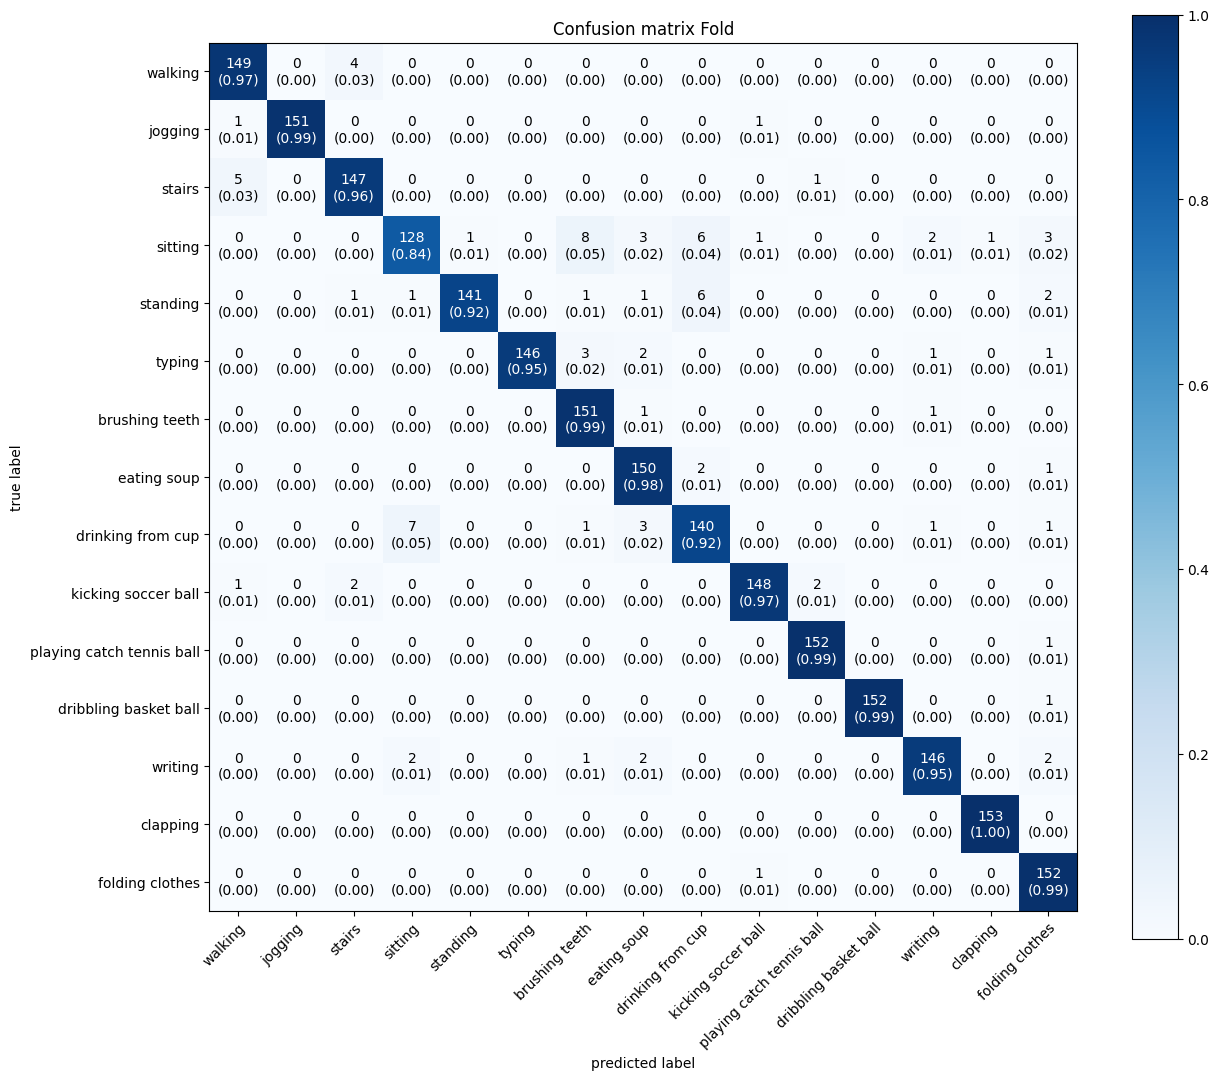

In [37]:
y_test_pred = rf_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

### Accuracy Per Activity

In [38]:
ACTIVITY_CODES_MAP.values()

dict_values(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing', 'brushing teeth', 'eating soup', 'eating chips', 'eating pasta', 'drinking from cup', 'eating sandwich', 'kicking soccer ball', 'playing catch tennis ball', 'dribbling basket ball', 'writing', 'clapping', 'folding clothes'])

In [39]:
cm_act = pd.DataFrame(conf_matrix,
                      index=rf_best_classifier.classes_,
                      columns=rf_best_classifier.classes_)

cm_act.columns = ACTIVITY_NAMES
cm_act.index = ACTIVITY_NAMES
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)
print(accuracy_per_activity)

                                  0
walking                    0.973856
jogging                    0.986928
stairs                     0.960784
sitting                    0.836601
standing                   0.921569
typing                     0.954248
brushing teeth             0.986928
eating soup                0.980392
drinking from cup          0.915033
kicking soccer ball        0.967320
playing catch tennis ball  0.993464
dribbling basket ball      0.993464
writing                    0.954248
clapping                   1.000000
folding clothes            0.993464


/tmp/ipykernel_2430969/3252733793.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(len(ACTIVITY_NAMES))],index=ACTIVITY_NAMES)


### Classification Report

In [40]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.96      0.97      0.96       153
           B       1.00      0.99      0.99       153
           C       0.95      0.96      0.96       153
           D       0.93      0.84      0.88       153
           E       0.99      0.92      0.96       153
           F       1.00      0.95      0.98       153
           G       0.92      0.99      0.95       153
           H       0.93      0.98      0.95       153
           K       0.91      0.92      0.91       153
           M       0.98      0.97      0.97       153
           O       0.98      0.99      0.99       153
           P       1.00      0.99      1.00       153
           Q       0.97      0.95      0.96       153
           R       0.99      1.00      1.00       153
           S       0.93      0.99      0.96       153

    accuracy                           0.96      2295
   macro avg       0.96      0.96      0.96      2295
weighted avg       0.96   

### Test Accuracy

In [41]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 96.12200435729848
